# Characterization of the segmentation errors 

This notebook takes as input two segmentations of an intensity image, a ground-truth segmentation and a predicted segmentation. Then, it estimates the rates of over and undersegmentation of the prediction according to the reference. The principles of this method may be found in the following:

Michelin G. Outils d’analyse d’images et recalage d’individus pour l’étude de la morphogenèse animale et végétale. Doctoral dissertation. 2016.

In [36]:
import os
import re
import numpy as np
import pandas as pd
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from matplotlib.transforms import Bbox

from timagetk.io import imread
from timagetk.components.spatial_image import SpatialImage
from timagetk.components.labelled_image import LabelledImage
from timagetk.visu.util import glasbey

from ctrl.image_overlap import fast_image_overlap3d

from pathlib import Path

## Data and parameters

Make sure to modify paths and filenames appropriately to match your file architecture.

In [37]:
main_directory = os.path.dirname(os.getcwd()) # for example

# - Set the predicted segmentation path
target_path = main_directory + '/data/segmentations/fm_paper/original/ps_orig/FM06_t026h_ORIGINAL_PS.inr.gz'

# - Set the ground-truth segmentation path
reference_path = main_directory + '/data/segmentations/fm_paper/gt/FM06_t026h_GT.inr.gz'

In [38]:
slice_index = 70
BACKGROUND_LABEL = 1

## Image loading

We assume that the images have the same shape and voxelsize. We also assume that the background label is equal to 1 in all images.

In [39]:
target_img = LabelledImage(imread(target_path), no_label_id=0)
reference_img = LabelledImage(imread(reference_path), no_label_id=0)

Loading image: /Users/manuelpett/Projects/seg_compare/data/segmentations/fm_paper/original/ps_orig/FM06_t026h_ORIGINAL_PS.inr.gz
done in 0.169s
Loading image: /Users/manuelpett/Projects/seg_compare/data/segmentations/fm_paper/gt/FM06_t026h_GT.inr.gz
done in 0.165s


## Image slice visualization

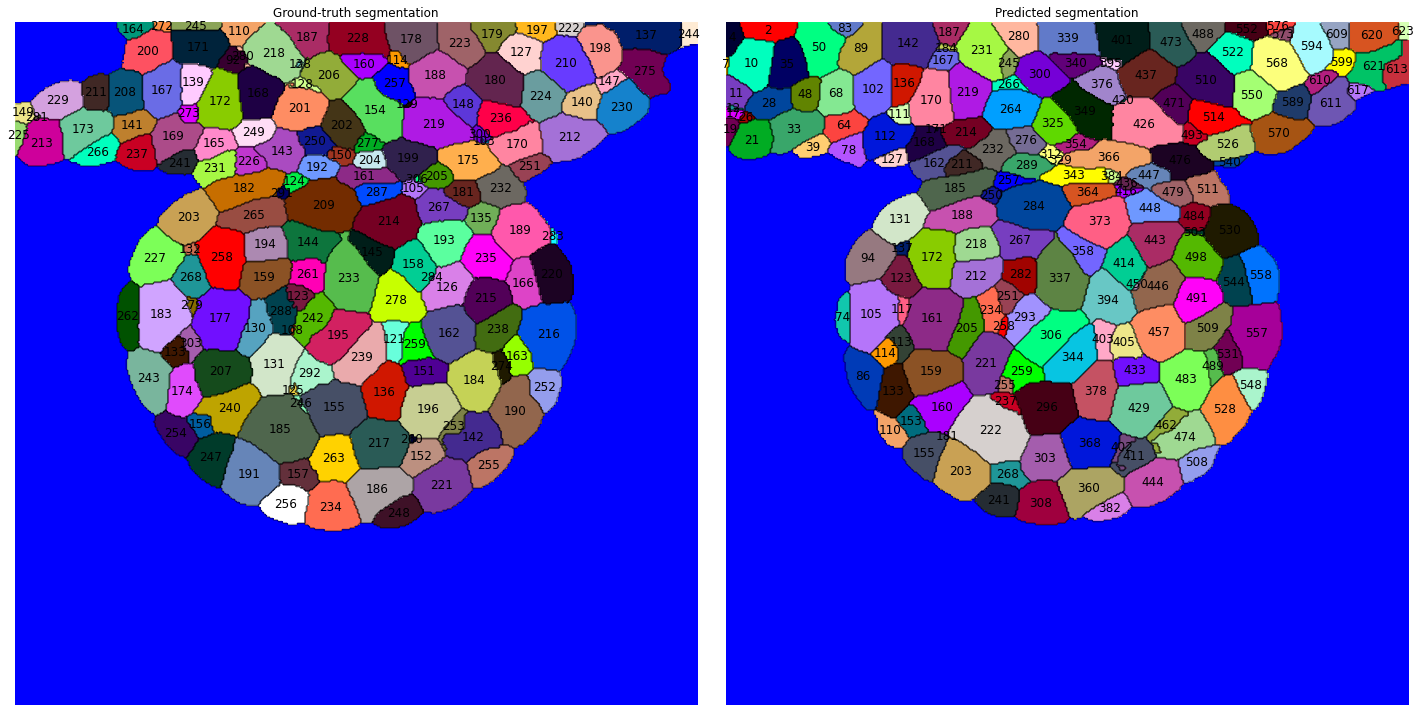

In [40]:
def plot_segmentation(img_seg, title, ax, slice_index, extent):
    slice_img = img_seg.get_array()[:,:,slice_index].T

    barycenter = nd.center_of_mass(np.ones_like(slice_img), slice_img, np.unique(slice_img))
    barycenter = dict(zip(np.unique(slice_img), barycenter * np.array(reference_img.voxelsize[:2])))

    ax.imshow(slice_img%256, cmap='glasbey', vmin=0, vmax=255, extent=extent, interpolation='none')
    ax.set_title(title)

    # - Add contour and label annotation
    for label in np.unique(slice_img):
        if label != 1:
            ax.contour(slice_img == label, linewidths=0.1, extent=extent,
                                 origin='upper', colors='k')
            ax.text(barycenter[label][1],
                              barycenter[label][0],
                              str(label),ha='center',va='center',size=12)
    ax.axis('off')
    
figure = plt.figure(0)
figure.clf()

extent = (0, reference_img.extent[0], reference_img.extent[1],0)

# - reference img
figure.add_subplot(1, 2, 1)
plot_segmentation(img_seg=reference_img, title='Ground-truth segmentation',
                  ax=figure.gca(), slice_index=slice_index, extent=extent)

# - target img
figure.add_subplot(1, 2, 2)
plot_segmentation(img_seg=target_img, title='Predicted segmentation',
                  ax=figure.gca(), slice_index=slice_index, extent=extent)

figure.set_size_inches(10*2,10)
figure.subplots_adjust(wspace=0,hspace=0)
figure.tight_layout()

## Characterization of the segmentation errors

The aim of the method is to associate reference and target (predicted) cells according to their reciprocal inclusion. 

### Calculation of the inclusion rates

A first step consists to get the inclusion rate of the reference cells into the target cells and vice-versa.

In [41]:
# - target --> reference
df_target = fast_image_overlap3d(target_img, reference_img, method='target_mother',
                                 ds=1, verbose=False)
df_target.columns = ['target', 'reference', 'target_in_reference']

# - reference --> target
df_reference = fast_image_overlap3d(target_img, reference_img, method='target_daughter',
                                    ds=1, verbose=False)
df_reference.columns = ['target', 'reference', 'reference_in_target']

print('Example of the inclusion of the reference cells into the target cells:')
print(df_reference.loc[df_reference.reference == 191])

Example of the inclusion of the reference cells into the target cells:
      target  reference  reference_in_target
189        1        191              0.15524
2744     138        191              0.00000
3024     153        191              0.00000
3048     155        191              0.00128
3545     180        191              0.00000
3577     181        191              0.00221
3689     186        191              0.00040
3813     191        191              0.00019
3978     203        191              0.82044
4269     220        191              0.00943
4328     222        191              0.00147
4623     237        191              0.00000
4680     241        191              0.00184
4734     244        191              0.00101
5060     262        191              0.00000
5178     268        191              0.00650
5271     274        191              0.00000


Inclusion rate close to 1 indicates that a large portion of the cell X is intersecting the cell Y.

### Background associations

The background associations are calculated by filtering all the cells that are included in the background. An inclusion rate threshold defined the cells that are retained.

In [42]:
thresh_background = 0.5 # if 50% of the cell X is included in the image background then they are associated

In [43]:
### - Solve the background associations - ###
# target --> reference background
target_background = df_target.target.loc[(df_target.reference == BACKGROUND_LABEL) &
                                         (df_target.target_in_reference >= thresh_background)].to_list()

# reference --> target background
reference_background = df_reference.reference.loc[(df_reference.target == BACKGROUND_LABEL) &
                                                  (df_reference.reference_in_target >= thresh_background)].to_list()

# - Add the background (make sure we remove them for the clique associations)
target_background.append(BACKGROUND_LABEL)
reference_background.append(BACKGROUND_LABEL)

# - Remove the cells associated with the background + backgrounds
df_target = df_target.loc[~((df_target.target.isin(target_background)) |
                            (df_target.reference == BACKGROUND_LABEL))].copy()
df_reference = df_reference.loc[~((df_reference.reference.isin(reference_background)) |
                                  (df_reference.target == BACKGROUND_LABEL))].copy()

In [44]:
print('Predicted cells that are associated with the ground-truth background: \n' + str(set(target_background)))

Predicted cells that are associated with the ground-truth background: 
{1, 2, 3, 4, 5, 7, 10, 11, 13, 271, 24, 35, 38, 40, 50, 75, 101, 613, 617}


### Other associations

For each remaining reference cells, we find the target cells that maximize its inclusion rate. We apply the same procedure for the target cells.

We obtain two dictionnary of one-to-one associations where each target and reference cells are associated to a reference or target cells respectively.

In [45]:
### - Get the 1 <--> 1 associations - ###
# - Associate each reference/target cell with the target/reference cell in which it is the most included
df_target = df_target.loc[df_target.groupby('target')['target_in_reference'].idxmax()]
df_reference = df_reference.loc[df_reference.groupby('reference')['reference_in_target'].idxmax()]

# - Convert in dict
target_in_reference = df_target[['target', 'reference']].set_index('target').to_dict()['reference']
reference_in_target = df_reference[['reference', 'target']].set_index('reference').to_dict()['target']

In [46]:
reference_in_target[191]

203

Then a bipartitate graph is built where:
* The left nodes represents the target cells
* The right nodes represents the reference cells
* The edges represents one-to-one associations between target and reference cells using the previous maximization procedure.

In [47]:
### - Build the associations (bijection, over-segmentation,...) - ###
# - Create a bipartite graph where nodes represent the A labels (left) and B labels (right)
#   and the edges the associations obtained using the max/min methods

# - Reindex the labels
target_labels = list(set(df_target.target.values) | set(df_reference.target.values))
reference_labels = list(set(df_target.reference.values) | set(df_reference.reference.values))

label_tp_list = [(m, 'l') for m in target_labels] + [(d, 'r') for d in reference_labels]
lg2nid = dict(zip(label_tp_list, range(len(label_tp_list))))

# - Create the graph
G = nx.Graph()

G.add_nodes_from([(nid, {'label': lab, 'group': g}) for (lab, g), nid in lg2nid.items()])

target_to_ref_list = [(lg2nid[(i, 'l')], lg2nid[(j, 'r')]) for i, j in target_in_reference.items()]
G.add_edges_from(target_to_ref_list)

ref_to_target_list = [(lg2nid[(i, 'r')], lg2nid[(j, 'l')]) for i, j in reference_in_target.items()]
G.add_edges_from(ref_to_target_list)

In a second step, we find al the connected sub-graphes of the bipartite graph. These connected sub-graphes corresponds to target and reference cells that are associated.

In [48]:
# - Overlap analysis
# - Get the  target_cells <--> reference_cells from the connected subgraph in G
connected_graph = [list(G.subgraph(c)) for c in nx.connected_components(G)]

# - Gather all the connected subgraph and reindex according to the image labels
nid2lg = {v: k for k, v in lg2nid.items()}

out_results = []
for c in connected_graph:
    if len(c) > 1:  # at least two labels
        target, reference = [], []
        for nid in c:
            if nid2lg[nid][1] == 'l':
                target.append(nid2lg[nid][0])  # label from target image
            else:
                reference.append(nid2lg[nid][0])  # label from reference image

        out_results.append({'target': target, 'reference': reference})

# - Add the background associations
# - target --> reference background
for lab in target_background:
    if lab != BACKGROUND_LABEL:  # ignore target background
        out_results.append({'target': [lab], 'reference': []})

# - reference --> target background
for lab in reference_background:
    if lab != BACKGROUND_LABEL:  # ignore reference background
        out_results.append({'target': [], 'reference': [lab]})

out_results = pd.DataFrame(out_results)

def segmentation_state(row):
    if len(row.reference) == 0:
        return 'background'
    elif len(row.target) == 0:
        return 'missing'
    elif len(row.target) == 1:
        if len(row.reference) == 1:
            return 'one-to-one'
        else:
            return 'under-segmentation'
    else:
        if len(row.reference) == 1:
            return 'over-segmentation'
        else:
            return 'misc.'
        
out_results['segmentation_state'] = out_results.apply(segmentation_state, axis=1) # add name for each type of association
print(out_results[:10])

     target        reference  segmentation_state
0    [6, 9]            [463]   over-segmentation
1       [8]  [746, 607, 516]  under-segmentation
2  [12, 14]            [309]   over-segmentation
3      [15]            [613]          one-to-one
4      [16]            [399]          one-to-one
5      [17]            [149]          one-to-one
6      [18]            [559]          one-to-one
7      [19]            [225]          one-to-one
8      [20]            [327]          one-to-one
9      [21]            [213]          one-to-one


The resulting dataframe allows to define the different type of associations:
* one-to-one 
* one-to-many : under-segmentation
* many-to-one : over-segmentation
* many-to-many : misc.
* one-to-background : if target cell is associated with the reference image background
* none-to-one : if a reference cell is not in the target image (associated with the image background)

### Proportion of each type of segmentation errors

From there, it is possible to calculate the portion of cells for each association type. Notice that in our case, the ground-truth background is not always segmented correctly. Thus, the target cells associated with the reference background are not counted. It is equivalent to restric the evaluation to the part of the image where there is an expertized tissue segmentation.

In [49]:
ignore_background = True

In [50]:
cell_statistics = {'one-to-one': 0, 'over-segmentation': 0, 'under-segmentation': 0, 'misc.': 0}

if not ignore_background:
    cell_statistics['background'] = 0 # add background

state_target = {lab: state for list_lab, state
                in zip(out_results.target.values, out_results.segmentation_state.values)
                for lab in list_lab if state in cell_statistics}

for lab, state in state_target.items():
    cell_statistics[state] += 1

total_cells = len(state_target)
cell_statistics = {state: np.around(val / total_cells * 100, 2) for state, val in cell_statistics.items()}

# - add the missing  cells : percentage of reference cells that are missing in the predicted segmentation
total_reference_cells = len(np.unique([item for sublist in out_results.reference.values for item in sublist]))
missing_cells = [item for sublist in out_results.reference.loc[out_results.segmentation_state == 'missing'].values for item in sublist]

total_missing = len(missing_cells)
cell_statistics['missing'] = np.around(total_missing/total_reference_cells * 100, 2)

print("Number of cells:", total_cells)
print("% of correct segmentations :", cell_statistics['one-to-one'])
print("% of oversegmentation :", cell_statistics['over-segmentation'])
print("% of undersegmentation :", cell_statistics['under-segmentation'])
print("% of missing ground-truth cells :", cell_statistics['missing'])

Number of cells: 607
% of correct segmentations : 86.49
% of oversegmentation : 3.46
% of undersegmentation : 5.93
% of missing ground-truth cells : 0.78


### Visualize comparison

In [51]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

In [52]:
def relabel_seg_img(img_seg, mapping_dict, ignore_missing_value=True):
    # provided solution @Divakar
    def map_values(a, bad_vals, update_vals):
        N = max(a.max(), max(bad_vals))+1
        mapar = np.empty(N, dtype=int)
        mapar[a] = a
        mapar[bad_vals] = update_vals
        out = mapar[a]
        return out
    
    # - Get type of the input
    dtype = 'uint16'

    # - Get image
    I = img_seg.get_array().copy().astype(dtype)

    # - Get mask of the missing values
    if ignore_missing_value:
        missing_val = list(set(img_seg.labels()) - set(mapping_dict))
        mask = np.isin(I, missing_val)

    # - Replace the value in image
    k = np.array(list(mapping_dict.keys()))
    v = np.array(list(mapping_dict.values()))

    I = map_values(I, k, v)

    if ignore_missing_value:
        I[mask] = img_seg.no_label_id

    return LabelledImage(SpatialImage(I, voxelsize=img_seg.voxelsize, dtype=dtype),
                         no_label_id=img_seg.no_label_id)

def visualize_comparison(target_img, reference_img, out_results, axis = 'z', slice_id=None, BACKGROUND_LABEL=1):
    # fonction that determines the segmentation comparison state
    color_map = {'missing': 5, 'background': 4, 'one-to-one': 0, 'under-segmentation': 2, 'over-segmentation': 1,
                 'misc.': 3}

    def segmentation_color(row):
        row_name = f'segmentation_state'
        return color_map[row[row_name]]

    if slice_id is None:
        if axis == 'x':
            slice_id = int(reference_img.shape[0]/2)
        elif axis == 'y':
            slice_id = int(reference_img.shape[1]/2)
        else:
            slice_id = int(reference_img.shape[2]/2)
    
    if target_img.is3D():
        target_img = LabelledImage(target_img.get_slice(slice_id, axis), no_label_id=0)

    if reference_img.is3D():
        reference_img = LabelledImage(reference_img.get_slice(slice_id, axis), no_label_id=0)

    vxs = reference_img.voxelsize
    im_extent = reference_img.extent
    mpl_extent = (-vxs[1] / 2, im_extent[1] + vxs[1] / 2, im_extent[0] + vxs[0] / 2, -vxs[0] / 2)

    # - Relabel target image according to the segmentation errors
    out_results['segmentation_color'] = out_results.apply(segmentation_color, axis=1)
    mapping_dict = {lab: c for lab_list, c in zip(out_results.target.values, out_results.segmentation_color.values) for
                    lab in lab_list}
    mapping_dict[BACKGROUND_LABEL] = 6
    mapping_dict = {**mapping_dict, **{lab: 5 for lab in target_img.labels() if lab not in mapping_dict}}

    target_comparison = relabel_seg_img(target_img, mapping_dict)

    fig, ax = plt.subplots(1, 3, figsize=(12, 12))

    list_img = [target_img, target_comparison, reference_img]
    title = ['Target Image', 'Segmentation Comparison', 'Reference Image']
    custom_map = ListedColormap(["tab:green", "tab:red", "tab:blue", "tab:gray", "lightgray", "yellow", "w"])
    cmap = ['glasbey', custom_map, 'glasbey']

    val_range = [(0, 255), (0, 7), (0, 255)]

    for ix, img in enumerate(list_img):
        ax[ix].imshow(img.get_array() % 255, cmap=cmap[ix], vmin=val_range[ix][0], vmax=val_range[ix][1], extent=mpl_extent, interpolation='none')
        ax[ix].set_title(title[ix])

        # - add borders
        if ix in [0, 2]:
            for lab in img.labels():
                if lab != 1:
                    ax[ix].contour(img.get_array() == lab, linewidths=0.1, extent=mpl_extent, origin='upper', colors='k')
        else:
            for lab in list_img[0].labels():
                if lab != 1:
                    ax[ix].contour(list_img[0].get_array() == lab, linewidths=0.1, extent=mpl_extent, origin='upper', colors='k')

    fig.subplots_adjust(bottom=0.05, wspace=0.33)

    # - Add custom legend
    legend_elements = [Patch(facecolor='tab:green', edgecolor='k', label='Correct'),
                       Patch(facecolor='tab:red', edgecolor='k', label='Over-segmentation'),
                       Patch(facecolor='tab:blue', edgecolor='k', label='Under-segmentation'),
                       Patch(facecolor='tab:gray', edgecolor='k', label='Misc.'),
                       Patch(facecolor='lightgray', edgecolor='k', label='In background')]

    fig.axes[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0, -1, 1, 1), ncol=2)

    fig.tight_layout()

    return fig

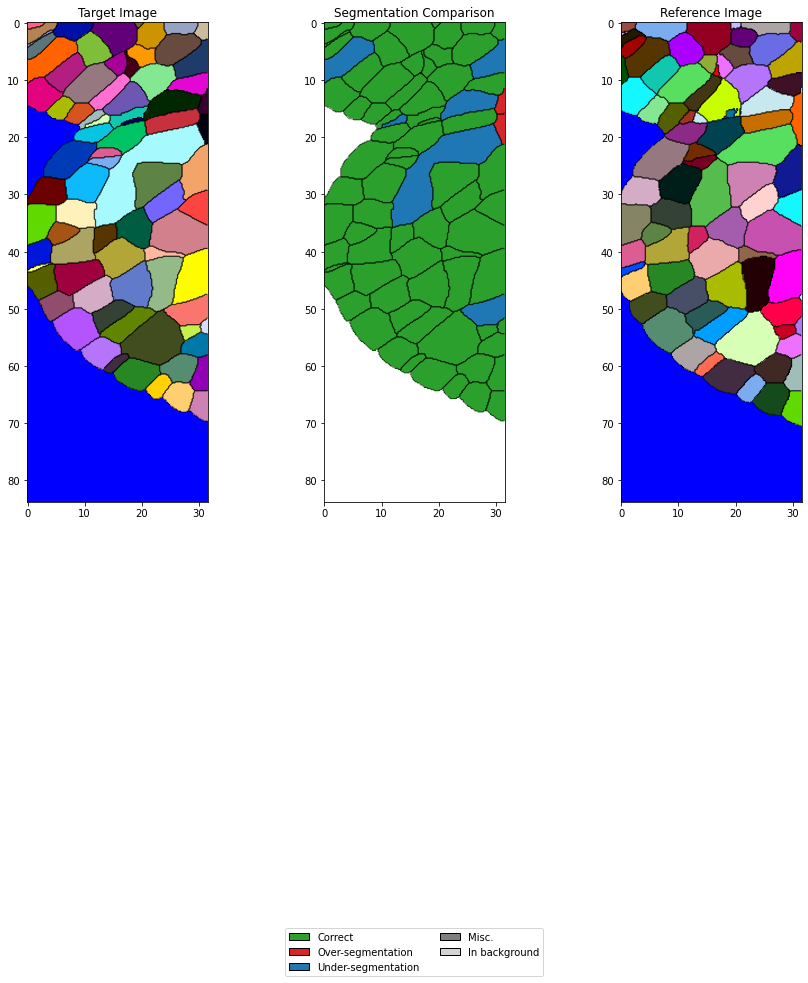

In [53]:
fig = visualize_comparison(target_img, reference_img, out_results, axis = 'x')